In [2]:
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
from matplotlib import patheffects
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter, maximum_filter, minimum_filter
import xarray as xr

In [3]:
# Plotting Max and Min data points
def plot_maxmin_points(lon, lat, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None):
    
    outline_effect = [patheffects.withStroke(linewidth=2.5, foreground='black')]

    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')

    mxy, mxx = np.where(data_ext == np.array(data))
    
    lon, lat = np.meshgrid(lons, lats)

    for i in range(len(mxy)):
        A = ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]], symbol, color=color, size=24,
                clip_on=True, clip_box=ax.bbox, horizontalalignment='center', verticalalignment='center',
                transform=transform)
        A.set_path_effects(outline_effect)
        
        a = np.array(data[mxy[i], mxx[i]])
        a_trunc = np.trunc(a)
        
        B = ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]],
                '\n' + str(a_trunc),
                color=color, size=12, clip_on=True, clip_box=ax.bbox, fontweight='bold',
                horizontalalignment='center', verticalalignment='top', transform=transform)
        B.set_path_effects(outline_effect)

In [4]:
#Open ERA5 dataset; change name accordingly to yours
ds = xr.open_dataset('EU_Single Levels.nc')
ds

<xarray.Dataset>
Dimensions:    (longitude: 141, latitude: 101, time: 72)
Coordinates:
  * longitude  (longitude) float32 105.0 105.2 105.5 105.8 ... 139.5 139.8 140.0
  * latitude   (latitude) float32 25.0 24.75 24.5 24.25 ... 0.75 0.5 0.25 0.0
  * time       (time) datetime64[ns] 2016-08-13 ... 2016-08-15T23:00:00
Data variables: (12/13)
    d2m        (time, latitude, longitude) float32 ...
    cape       (time, latitude, longitude) float32 ...
    cin        (time, latitude, longitude) float32 ...
    cp         (time, latitude, longitude) float32 ...
    z          (time, latitude, longitude) float32 ...
    hcc        (time, latitude, longitude) float32 ...
    ...         ...
    lsp        (time, latitude, longitude) float32 ...
    lcc        (time, latitude, longitude) float32 ...
    msl        (time, latitude, longitude) float32 ...
    mcc        (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
    totalx     (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-08-05 08:13:16 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [5]:
#Open another (optional) ERA5 dataset; change name accordingly to yours
ds1 = xr.open_dataset('EU_Pressure Levels.nc')
ds1

<xarray.Dataset>
Dimensions:    (longitude: 141, latitude: 101, level: 20, time: 72)
Coordinates:
  * longitude  (longitude) float32 105.0 105.2 105.5 105.8 ... 139.5 139.8 140.0
  * latitude   (latitude) float32 25.0 24.75 24.5 24.25 ... 0.75 0.5 0.25 0.0
  * level      (level) int32 1 100 150 200 250 300 ... 750 800 850 900 950 1000
  * time       (time) datetime64[ns] 2016-08-13 ... 2016-08-15T23:00:00
Data variables:
    d          (time, level, latitude, longitude) float32 ...
    z          (time, level, latitude, longitude) float32 ...
    pv         (time, level, latitude, longitude) float32 ...
    r          (time, level, latitude, longitude) float32 ...
    t          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
    w          (time, level, latitude, longitude) float32 ...
    vo         (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-08-05 07:44:20 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [6]:
# Grab lat/lon values (NAM will be 2D)
lats = ds.latitude
lons = ds.longitude

# Select and grab data
mslp = ds['msl']
div = ds1['d']
u_wind = ds1['u']
v_wind = ds1['v']

# Select U and V-components at 850 hPa
uwnd_850 = gaussian_filter(u_wind.sel(level=850).data[30], sigma=3.0) * units('m/s')
vwnd_850 = gaussian_filter(v_wind.sel(level=850).data[30], sigma=3.0) * units('m/s')

# Select U and V-components at 500 hPa
uwnd_500 = gaussian_filter(u_wind.sel(level=500).data[30], sigma=3.0) * units('m/s')
vwnd_500 = gaussian_filter(v_wind.sel(level=500).data[30], sigma=3.0) * units('m/s')

# Calculate U and V-wind shear components
uwnd_shear = uwnd_500 - uwnd_850
vwnd_shear = vwnd_500 - vwnd_850

# Transform m/s into knots
uwnd_kt = uwnd_shear.to('kt')
vwnd_kt = vwnd_shear.to('kt')

# Select and grab MSLP
mslp_surf = gaussian_filter(mslp.data[30], sigma=3.0) * units.pascal
mslp_hpa = mslp_surf.to(units.hectopascal)

diverge = gaussian_filter(div.sel(level=600).data[30], sigma=3.0) * units('s**-1')

vtime = datetime.strptime(str(ds1.time.data[30].astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

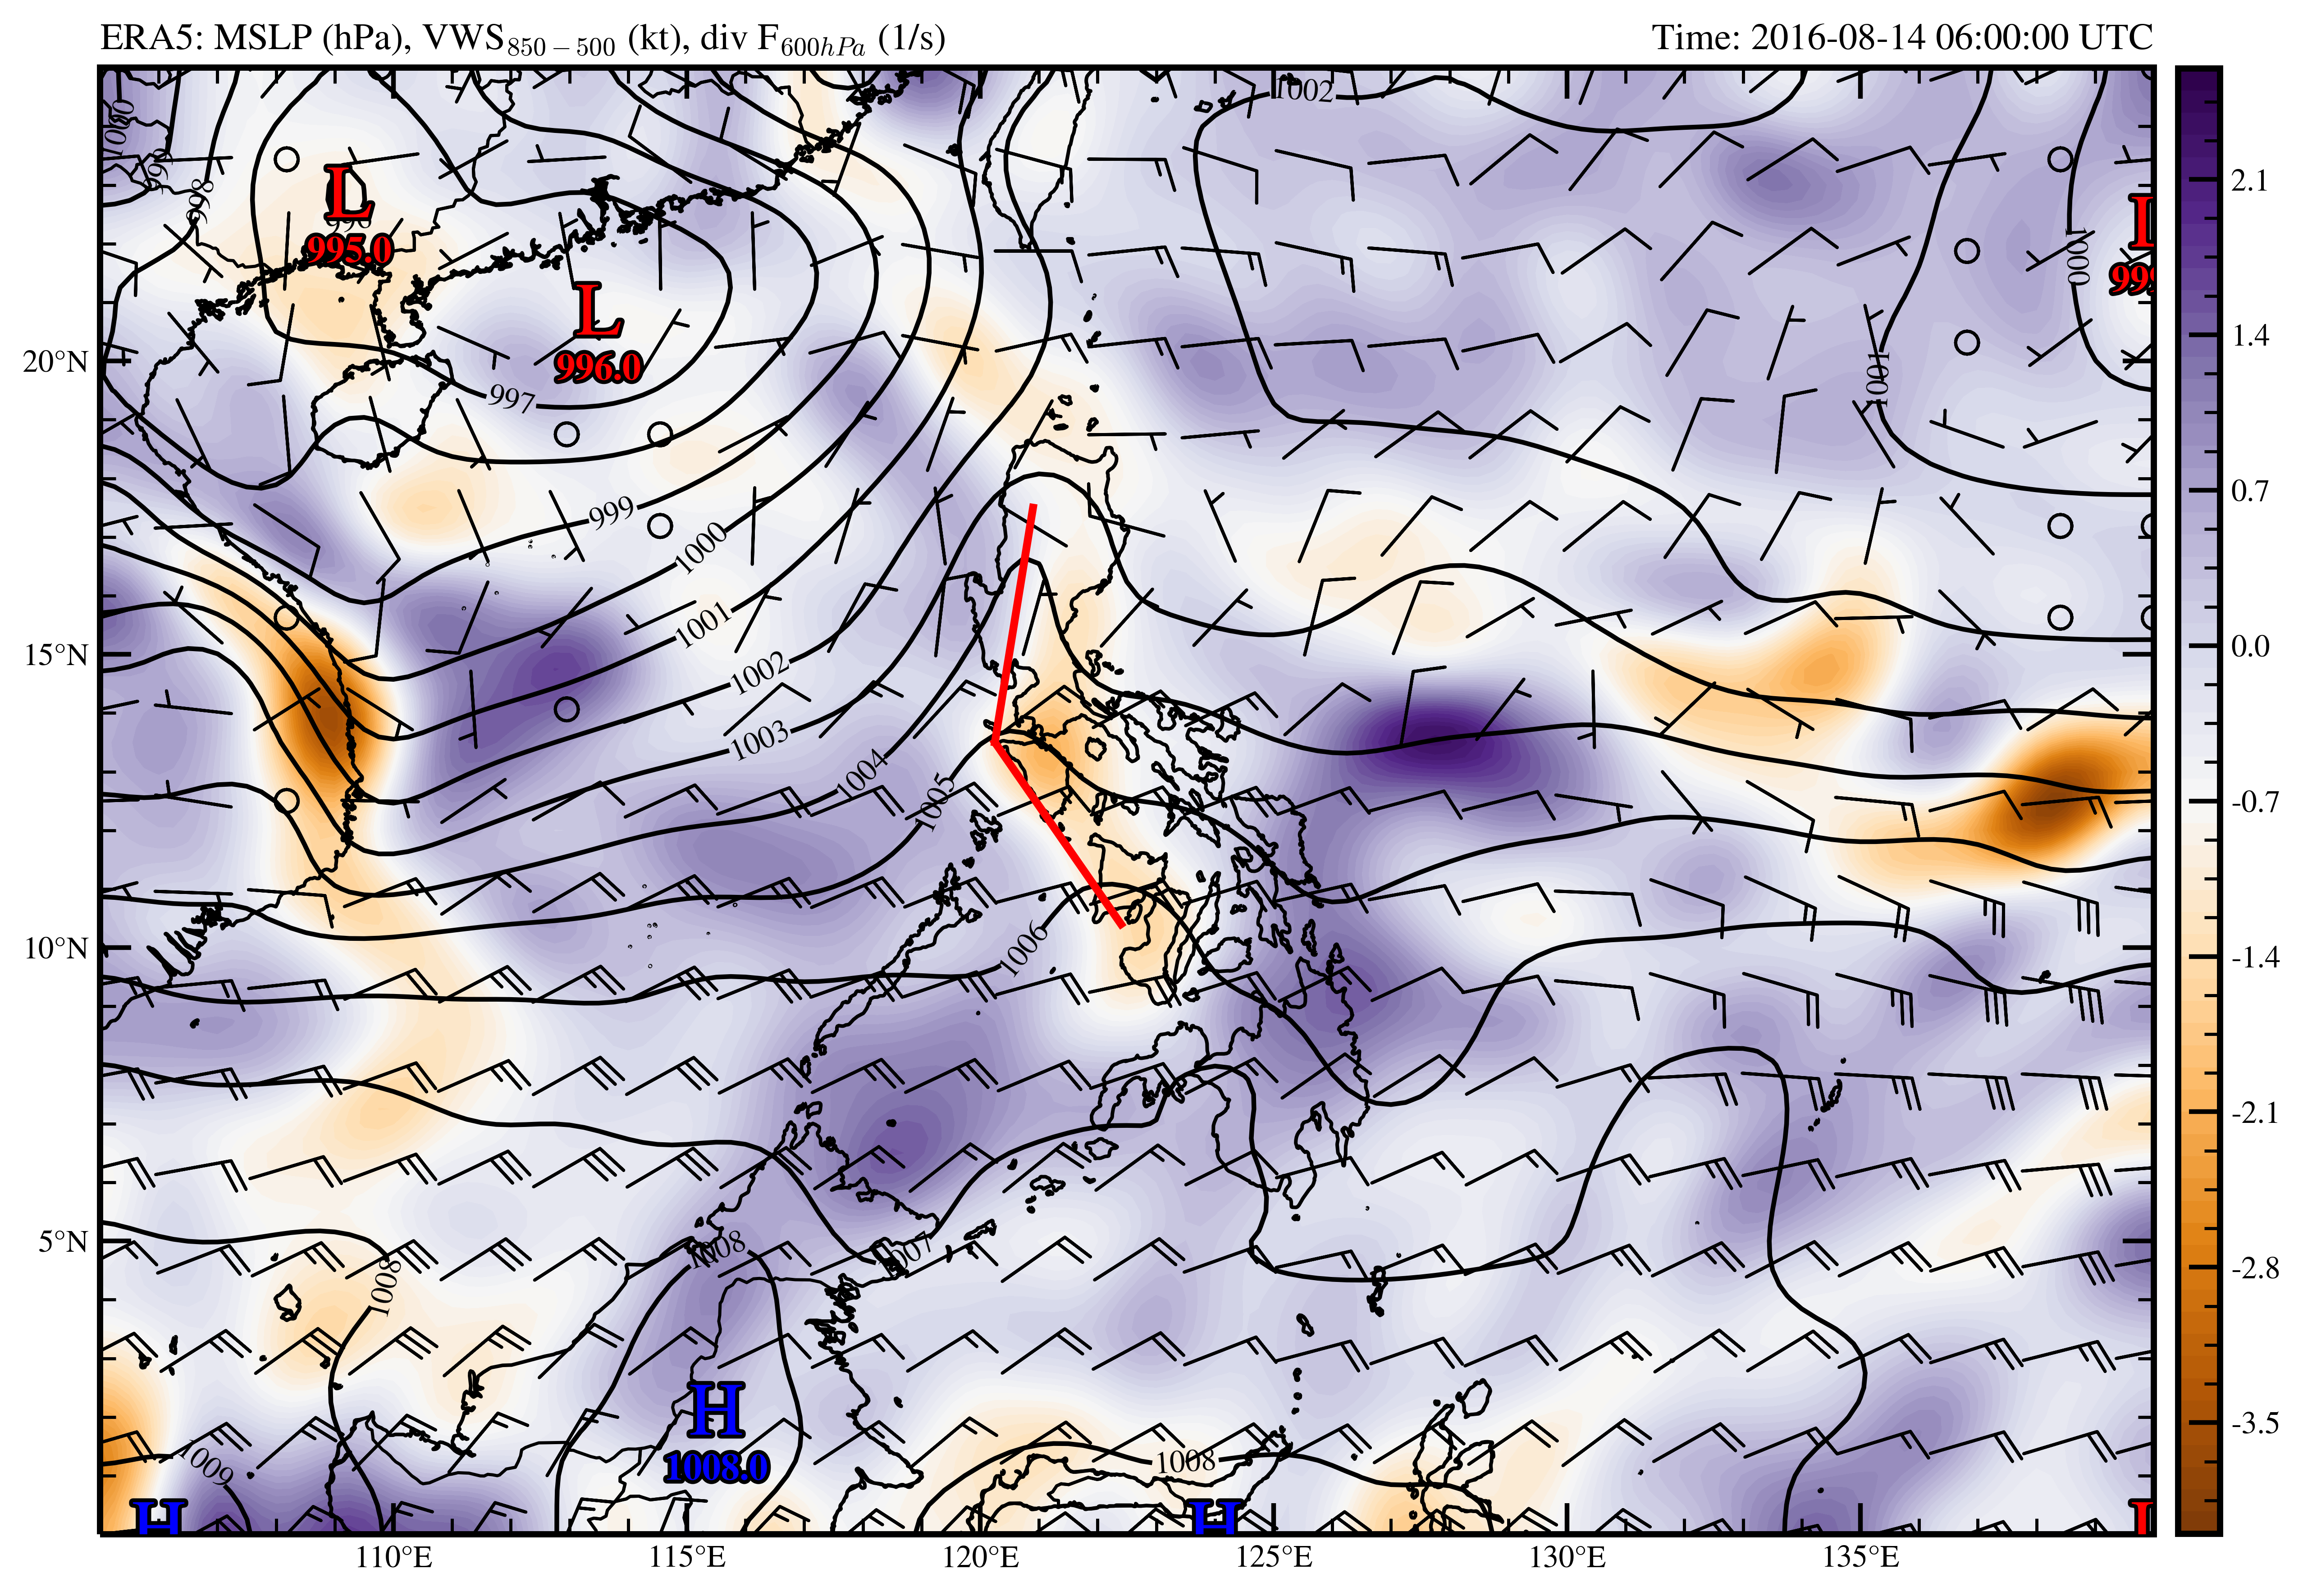

In [10]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.PlateCarree()

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=datacrs)
ax.set_extent([105, 140, 0, 25], mapcrs)

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1.15)
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot Divergence at 600 hPa
div_range = np.arange(-0.000040, 0.000026, 0.000001)
fmt = '%1.5f'
dive = ax.contourf(lons, lats, diverge, div_range, cmap='PuOr',
                 transform=datacrs)
cbar = plt.colorbar(dive, orientation='vertical', pad=0.01, aspect=35, shrink=0.542, 
                    ticks=[-0.000035, -0.000028, -0.000021, -0.000014, -0.000007, 
                           0.000000, 0.000007, 0.000014, 0.000021], format=fmt)
cbar.ax.set_yticklabels(['-3.5','-2.8', '-2.1', '-1.4', '-0.7', '0.0', 
                         '0.7', '1.4', '2.1'])
cbar.ax.minorticks_on()
cbar.ax.tick_params(which='major', length=10, width=1.5, top=True, right=True, direction='in')
cbar.ax.tick_params(which='minor', length=5, width=1, top=True, right=True, direction='in')

# Plot 850-500 hPa Wind Shear
shear = ax.barbs(lons, lats, uwnd_kt, vwnd_kt, color='black', 
         pivot='middle', regrid_shape=17, transform=datacrs)

# Plot MSLP Contour
MSLP_range = np.arange(995, 1010, 1)
prs = ax.contour(lons, lats, mslp_hpa, MSLP_range, colors='k',
                 transform=datacrs, zorder=1)
ax.clabel(prs, fmt='%d')

# Plot Highs and Lows (Min/Max) values of MSLP
plot_maxmin_points(lons, lats, mslp_hpa, 'max', 60, symbol='H', color='b', transform=datacrs)
plot_maxmin_points(lons, lats, mslp_hpa, 'min', 20, symbol='L', color='r', transform=datacrs)

# Create a line(s) that highlights the surface trough
point1 = dict(lon=120.90, lat=17.50)
point2 = dict(lon=120.25, lat=13.50)
lon_p = [point1['lon'], point2['lon']]
lat_p = [point1['lat'], point2['lat']]
ax.plot(lon_p, lat_p, color='red', linewidth=2.5, transform=ccrs.Geodetic())

point3 = dict(lon=120.25, lat=13.50)
point4 = dict(lon=122.40, lat=10.40)
lon_p1 = [point3['lon'], point4['lon']]
lat_p1 = [point3['lat'], point4['lat']]
ax.plot(lon_p1, lat_p1, color='red', linewidth=2.5, transform=ccrs.Geodetic())

# Make some nice titles for the plot (one right, one left)
plt.title('ERA5: MSLP (hPa), VWS$_{850-500}$ (kt), div F$_{600hPa}$ (1/s)', 
          loc='left')
plt.title('Time: {} UTC'.format(vtime), loc='right')

# Set X and Y-ticks for Latitude and Longitude Coordinates
ax.set_yticks(lats, 5, crs=ccrs.PlateCarree())
ax.set_xticks(lons, 5, crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
long_formatter = cticker.LongitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
ax.xaxis.set_major_formatter(long_formatter)
ax.set_xticks(ax.get_xticks()[1:7]) #Hide end points of longitude tickmarks
ax.set_yticks(ax.get_yticks()[1:5]) #Hide end points of latitude tickmarks
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=1.5, top=True, right=True, direction='in')
ax.tick_params(which='minor', length=5, width=1, top=True, right=True, direction='in')

# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['figure.dpi'] = 500
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.savefig('MSLP, Div, VWS.jpg', bbox_inches="tight")
plt.show()